In [1]:
# %load_ext lab_black

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import mlflow
from pycaret.classification import setup, compare_models, models, create_app, create_model
from pycaret.datasets import get_data

plt.style.use("seaborn")

RANDOM_STATE = 1234

In [2]:
# df = pd.read_csv(
#     "/tf/notebooks/CEIA-machine_learning/tp-individual/fraud-detection.csv"
# )
df = pd.read_csv(
    "fraud-detection.csv"
)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# df = df.head(10000)

In [4]:
print(f"Cantidad de datos en el dataset: {df.shape[0]}")
print(f"Cantidad de 'nameOrig' distintos: {df['nameOrig'].unique().shape[0]}")
print(f"Cantidad de 'nameDest' distintos: {df['nameDest'].unique().shape[0]}")
print(f"Cantidad de 'type' distintos: {df['type'].unique().shape[0]}")

Cantidad de datos en el dataset: 6362620
Cantidad de 'nameOrig' distintos: 6353307
Cantidad de 'nameDest' distintos: 2722362
Cantidad de 'type' distintos: 5


*'nameOrig'* y *'nameDest'* son los nombres de las cuentas afectadas, estos datos son unicos por cuenta, por lo tanto no son relevantes para el problema a resolver.

In [5]:
df.drop(columns=["nameOrig", "nameDest"], inplace=True)
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


Para evaluar si existe relación lineal entre variables, se grafica la matriz de correlación.

<AxesSubplot:>

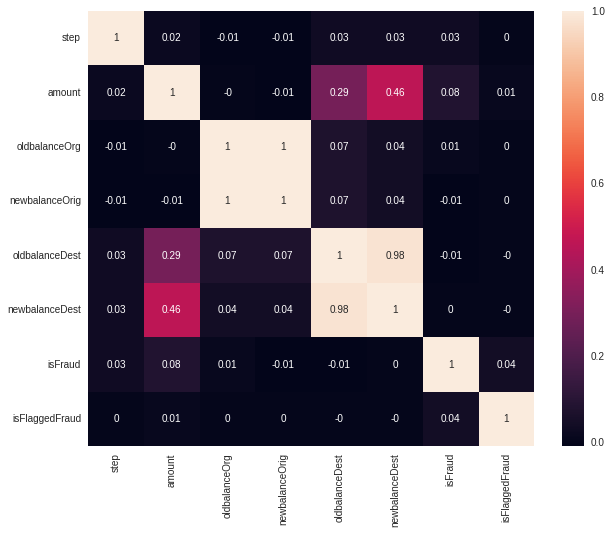

In [6]:
# Matriz de correlación, redondeo a 2 decimales
correlation_matrix = df.corr().round(2)
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(data=correlation_matrix, annot=True, ax=axes)

Como se ve hay correlación lineal entre *'oldbalanceOgs'* y *'newbalanceOrig'*, y entre *'oldbalanceDest'* y *'newbalanceDest'*. Esto el lógico ya que lo que se descuenta de una cuenta es lo que se le suma a otra. Eliminamos las columnas *'newbalanceOrig'* y *'newbalanceDest'*.

In [7]:
df.drop(columns=["newbalanceOrig", "newbalanceDest"], inplace=True)
df.head()

,step,type,amount,oldbalanceOrg,oldbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,21182.0,1,0
4,1,PAYMENT,11668.14,41554.0,0.0,0,0


Vemos si existen valores faltantes.

In [8]:
df.isnull().sum(axis=0)

step              0
type              0
amount            0
oldbalanceOrg     0
oldbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

En el dataset no hay valores faltantes.

Analizamos el balanceo de las clases de target

Se utilizará pycaret para probar como funcionan distintos modelos. Se utiliza la función *'setup'* para realizar un preprocesaimento de los datos. A continuación se detallan el preprocesamiento a realizar.

- La variable target será la columna *'isFraud'*
- El 90% de los datos serán utilizados para entrenamiento y el 10% para test.
- Se normalizarán las variables utilizando el método *'zscore'*
- Se aplicará PCA y se seleccionarán las componentes que contengan el 90% de la varianza.
- Se removerán todas las componentes que presenten una correlación mayor a %90.
- Se balancean las clases utilizando el método *'SMOTE'*, que genera ejemplos sintéticos de la clase minoritaria.
- Se mezclan los datos aleatoriamente antes de dividir los sets de entrenamiento y test, a su vez esto se hace de manera estratificada para que haya igual cantidad de valores de las clases objetivo en cada conjunto de datos.
- Para el entrenamiento se utiliza una separácion *'k-fold'* de 5 folds.
- Se utiliza una semilla aleatoria concreta para poder reproducir el experimento.

In [9]:
clf1 = setup(
    df,
    target="isFraud",
    train_size=0.9,
    # preprocess = False,
    normalize=True,
    normalize_method="zscore",
    pca=True,
    pca_components=0.9,
    # # remove_outliers = True,
    # # outliters_threshold = 0.05,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.9,
    fix_imbalance=True,  # SMOTE method
    data_split_shuffle=True,
    data_split_stratify=True,
    fold_strategy="stratifiedkfold",
    fold=5,
    session_id=RANDOM_STATE,
    silent=True,
    log_experiment=True,
    experiment_name="fraud-detection-1",
    use_gpu=True,
)

,Description,Value
0,session_id,1234
1,Target,isFraud
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(6362620, 7)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


Vemos que modelos de regresión pueden ser aplicados.

In [10]:
models()

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [11]:
best_model = compare_models(
    include=[
        "dt",  # Decision Tree Classifier
        "svm",  # SVM - Linear Kernel
        "lr",  # Logistic Regression
        RandomForestClassifier(n_estimators=10, random_state=RANDOM_STATE)
    ],
    fold=5,
    cross_validation=True,
)

IntProgress(value=0, description='Processing: ', max=24)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:34:27
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Decision Tree Classifier,0.9972,0.8863,0.7752,0.2861,0.4180,0.4169,0.4699,130.3680
1,SVM - Linear Kernel,0.8335,0.0000,0.7372,0.0057,0.0113,0.0088,0.0549,12.2880
2,Logistic Regression,0.7890,0.8711,0.7474,0.0046,0.0091,0.0065,0.0472,11.0320


In [ ]:
# lr = create_model('lr')

: 

: 

In [ ]:
# !mlflow ui

: 

: 

In [ ]:
# type_dummies = pd.get_dummies(df['type'], prefix='type')
# df.drop(columns=['type'], inplace=True)
# type_dummies

: 

: 

In [ ]:
# df_to_normalize = df.drop(columns=['isFraud', 'isFlaggedFraud'])

# scaler = StandardScaler().fit(df_to_normalize)
# data_normalized = scaler.transform(df_to_normalize)
# df_normalized = pd.DataFrame(data_normalized, columns=df_to_normalize.columns)

: 

: 

In [ ]:
# df = pd.concat([df_normalized, df[['isFraud', 'isFlaggedFraud']], type_dummies], axis=1)
# df

: 

: 

In [ ]:
# df_x = df.drop(columns=['isFraud'])
# df_y = df['isFraud']

# x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.1, random_state=23, stratify=df_y)

# print(f'x train shape: {x_train.shape}')
# print(f'x test shape: {x_test.shape}')
# print(f'y train shape: {y_train.shape}')
# print(f'y test shape: {y_test.shape}')

: 

: 

In [ ]:
# rf = RandomForestClassifier(n_estimators=10, random_state=23, class_weight='balanced_subsample')
# rf.fit(x_train, y_train);

: 

: 

In [ ]:
# rf.score(x_test, y_test)

: 

: 

In [ ]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=0.9).fit(x_train)
# x_train_pca = pca.transform(x_train)

: 

: 

In [ ]:
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.ensemble import RandomForestClassifier
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=23)
# rf = RandomForestClassifier(n_estimators=10, random_state=23, class_weight='balanced_subsample')
# scores = cross_val_score(rf, x_train_pca, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

: 

: 

In [ ]:
# scores['test_score'].mean()

: 

: 

In [ ]:
# y_pred = scores['estimator'][0].predict(x_test)

: 

: 

In [ ]:
# np.mean(scores)

# rf.fit(x_train, y_train);

: 

: 

In [ ]:
# df['isFraud'].value_counts()

: 

: 

In [ ]:
# from mlxtend.plotting import plot_confusion_matrix
# from sklearn.metrics import confusion_matrix

# # y_pred = rf.predict(x_test)

# matriz = confusion_matrix(y_test,y_pred)
# plot_confusion_matrix(conf_mat=matriz, figsize=(6,6), show_normed=False)
# plt.tight_layout()

: 

: 